# Investigating the Indian startup ecosystem

## Description
The objective of this project is to analyse the indian start-up investment data over the course of four years (2018-2021) to find out which funding stages are very attractive to investors and at what risk level. 

# GOAL
The goal of this project is to propose the best indian start-up to invest.

### Null Hypothesis 
Investment amounts received by start-ups have no relation to sectors they operate in.


### Alternate Hypothesis
There is a relationship between investment amounts received by start-ups and the sectors they operate in

## Analytical Questions
1. Does location affect the amount of funding or investments?
2. Does the sector of start up affect the fundings?
3. How many companies need funding and are at what level of funding ?
4. Which stages give out the highest investment amounts?
5. Which cities have the highest number of startups and at what levels?
6. What are the levels of funding the startups are receiving per year?

In [373]:
#Libraries imported
import MySQLdb
import sqlalchemy as sa
import pyodbc     
from dotenv import dotenv_values    #import the dotenv_values function from the dotenv package
import pandas as pd
import warnings 


In [374]:
env_variables= dotenv_values('logins.env')
database= env_variables.get('database')
server = env_variables.get('server')
username = env_variables.get('username')
password = env_variables.get('password')



# Data Understanding

- There are four data sources to work with (2 SQL and 2 CSVs)
- Explore data
- Verify data quality

### Connecting to the dapDB to extract the 2020 and 2021 data

In [375]:
#Connecting to the database to analyse the 2020-2021 data

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [376]:
#query the 2020 startup funding data

query = "SELECT * FROM LP1_startup_funding2020"

data_2020 = pd.read_sql(query, connection)
data_2020.columns

c:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Index(['Company_Brand', 'Founded', 'HeadQuarter', 'Sector', 'What_it_does',
       'Founders', 'Investor', 'Amount', 'Stage', 'column10'],
      dtype='object')

In [377]:
data_2020.head(2)
data_2020['Investment_year'] = '2020'

In [378]:
#Checking the datatypes of the columns
datatypes = data_2020.dtypes
datatypes

Company_Brand       object
Founded            float64
HeadQuarter         object
Sector              object
What_it_does        object
Founders            object
Investor            object
Amount             float64
Stage               object
column10            object
Investment_year     object
dtype: object

In [379]:
data_2020.Amount.unique()

array([2.0000000e+05, 1.0000000e+05,           nan, 4.0000000e+05,
       3.4000000e+05, 6.0000000e+05, 4.5000000e+07, 1.0000000e+06,
       2.0000000e+06, 1.2000000e+06, 6.6000000e+08, 1.2000000e+05,
       7.5000000e+06, 5.0000000e+06, 5.0000000e+05, 3.0000000e+06,
       1.0000000e+07, 1.4500000e+08, 1.0000000e+08, 2.1000000e+07,
       4.0000000e+06, 2.0000000e+07, 5.6000000e+05, 2.7500000e+05,
       4.5000000e+06, 1.5000000e+07, 3.9000000e+08, 7.0000000e+06,
       5.1000000e+06, 7.0000000e+08, 2.3000000e+06, 7.0000000e+05,
       1.9000000e+07, 9.0000000e+06, 4.0000000e+07, 7.5000000e+05,
       1.5000000e+06, 7.8000000e+06, 5.0000000e+07, 8.0000000e+07,
       3.0000000e+07, 1.7000000e+06, 2.5000000e+06, 4.0000000e+04,
       3.3000000e+07, 3.5000000e+07, 3.0000000e+05, 2.5000000e+07,
       3.5000000e+06, 2.0000000e+08, 6.0000000e+06, 1.3000000e+06,
       4.1000000e+06, 5.7500000e+05, 8.0000000e+05, 2.8000000e+07,
       1.8000000e+07, 3.2000000e+06, 9.0000000e+05, 2.5000000e

In [380]:
#query the 2021 startup funding data
query = "SELECT * FROM LP1_startup_funding2021"

data_2021 = pd.read_sql(query, connection)
data_2021.head(1)


c:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage
0,Unbox Robotics,"$2,019.00",Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First","$1,200,000",Pre-series A


In [381]:
data_2021.Amount.unique()
data_2021.shape

(1209, 9)

In [382]:
#Checking the datatypes of the columns
datatypes = data_2021.dtypes
datatypes

Company_Brand     object
Founded          float64
HeadQuarter       object
Sector            object
What_it_does      object
Founders          object
Investor          object
Amount            object
Stage             object
dtype: object

In [383]:
data_2021[data_2021['Amount'].str.contains('$', na = False)]
data_2021['Amount']=data_2021.Amount.str.replace('\W', '', regex=True)
data_2021.head(2)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage
0,Unbox Robotics,"$2,019.00",Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",1200000,Pre-series A
1,upGrad,"$2,015.00",Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",120000000,None


In [384]:
#combining the Stage and Amount columns since there are mixed data entry errors
data_2021['new'] =  data_2021['Investor'].fillna('inv') +data_2021['Amount'].astype(str) + data_2021['Stage'].fillna('ab') 
#data_2021['new']

In [385]:
data_2021['Amount_new']=data_2021['new'].str.extract('(\d+)')
data_2021.head(1)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage,new,Amount_new
0,Unbox Robotics,"$2,019.00",Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",1200000,Pre-series A,"BEENEXT, Entrepreneur First1200000Pre-series A",1200000


In [386]:
#Removing the dollar symbol from the 2021 amount
data_2021.drop(columns=['new','Amount'],inplace=True)



In [387]:
data_2021.head(2)
data_2021['Investment_year'] = '2021'

In [388]:
#Renaming the Amount_new column
data_2021.rename(columns={'Amount_new':'Amount'}, inplace=True)

#2021 data cleaned!!!!!!!!!!!

In [389]:
#Reading 2018 data from the csv files
#assump
data_2018=pd.read_csv('startup_funding_2018_2019\startup_funding2018.csv')
data_2018.head(5)

,Company Name,Industry,Round/Series,Amount,Location,About Company
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f..."
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...


In [390]:
#Changing column names of 2018 data to match all other datasets
data_2018.rename(columns={'Company Name':'Company_Brand','Industry':'Sector', 'Round/Series':'Stage', 'Location':'HeadQuarter', 'About Company':'What_it_does'}, inplace=True)
data_2018.head(5)

,Company_Brand,Sector,Stage,Amount,HeadQuarter,What_it_does
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f..."
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...


In [391]:
def curr_converter(df,rate):
    amount_new=[]
    for a in df:
        if a.startswith('$'):
            
            amount_new.append(a.split('$')[1].replace(',',''))
        elif a.startswith('₹'): 
            
            amount_new.append(float((a.split('₹')[1]).replace(',',''))/rate )  
        else :
            amount_new.append(a)    
    return amount_new

In [392]:
#Removing the Lahk symbol
exch_rate= 158.38
amount_list=data_2018.Amount.tolist()
amount_new=curr_converter(amount_list,exch_rate)
data_2018['Amount']=amount_new
data_2018['Investment_year'] = '2018'

In [393]:
#Reading 2019 data from the csv files
data_2019=pd.read_csv('startup_funding_2018_2019\startup_funding2019.csv')
data_2019.head(5)

,Company/Brand,Founded,HeadQuarter,Sector,What it does,Founders,Investor,Amount($),Stage
0,Bombay Shaving,NaN,NaN,Ecommerce,Provides a range of male grooming products,Shantanu Deshpande,Sixth Sense Ventures,"$6,300,000",NaN
1,Ruangguru,"$2,014.00",Mumbai,Edtech,A learning platform that provides topic-based ...,"Adamas Belva Syah Devara, Iman Usman.",General Atlantic,"$150,000,000",Series C
2,Eduisfun,NaN,Mumbai,Edtech,It aims to make learning fun via games.,Jatin Solanki,"Deepak Parekh, Amitabh Bachchan, Piyush Pandey","$28,000,000",Fresh funding
3,HomeLane,"$2,014.00",Chennai,Interior design,Provides interior designing solutions,"Srikanth Iyer, Rama Harinath","Evolvence India Fund (EIF), Pidilite Group, FJ...","$30,000,000",Series D
4,Nu Genes,"$2,004.00",Telangana,AgriTech,"It is a seed company engaged in production, pr...",Narayana Reddy Punyala,Innovation in Food and Agriculture (IFA),"$6,000,000",NaN


In [394]:
#Changing column names of 2019 data to match all other datasets
data_2019.rename(columns={'Company/Brand':'Company_Brand', 'What it does':'What_it_does', 'Amount($)':'Amount'}, inplace=True)
data_2019.columns

Index(['Company_Brand', 'Founded', 'HeadQuarter', 'Sector', 'What_it_does',
       'Founders', 'Investor', 'Amount', 'Stage'],
      dtype='object')

In [395]:
#Removing the Lahk symbol
exch_rate= 177.13
amount_list=data_2019.Amount.tolist()
amount_new=curr_converter(amount_list,exch_rate)
data_2019['Amount']=amount_new
data_2019['Investment_year'] = '2019'

### Merging datasets

In [396]:
#Concating 2020 and 2021 data since they have a similar structure
pd.set_option('display.max_rows', None)
final_df = pd.concat([data_2021,data_2020,data_2019,data_2018],axis=0,ignore_index=True)
final_df.head(5)
final_df.shape

(2879, 11)

In [397]:
#Saving the combined dataset to xlsx
final_df.to_csv("startup_funding_2018_2019\combined.csv",index=False
             ) 

# Data Cleaning & Exploration

In [398]:
#Considering the columns of interest and reindexing
df= pd.read_csv('startup_funding_2018_2019\combined.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Company_Brand    2879 non-null   object 
 1   Founded          2110 non-null   float64
 2   HeadQuarter      2765 non-null   object 
 3   Sector           2861 non-null   object 
 4   What_it_does     2879 non-null   object 
 5   Founders         2334 non-null   object 
 6   Investor         2253 non-null   object 
 7   Stage            1941 non-null   object 
 8   Amount           2494 non-null   object 
 9   Investment_year  2879 non-null   int64  
 10  column10         2 non-null      object 
dtypes: float64(1), int64(1), object(9)
memory usage: 247.5+ KB


In [399]:
df.shape

(2879, 11)

In [400]:
#split HQ column into two columns
df[['Town', 'Other']] = df['HeadQuarter'].str.split(',', 1, expand=True)
df[['City', 'Country']] = df['Other'].str.split(',', 1, expand=True)
#df


In [401]:
# Function to fill new column based on conditions
def fill_new_column(row):
    if row['Town'] != '':
        return row['Town']
    else:
        return row['City']
    
# Create a new column filled with values from one column or default value if empty
df['Headquarter_City'] = df.apply(fill_new_column, axis=1)    

df.head(2)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,column10,Town,Other,City,Country,Headquarter_City
0,Unbox Robotics,"$2,019.00",Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,1200000,2021,NaN,Bangalore,None,None,None,Bangalore
1,upGrad,"$2,015.00",Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",NaN,120000000,2021,NaN,Mumbai,None,None,None,Mumbai


In [402]:
df.Headquarter_City.tolist()

['Bangalore',
 'Mumbai',
 'Mumbai',
 'Mumbai',
 'Gurugram',
 'New Delhi',
 'Bangalore',
 'Mumbai',
 'Bangalore',
 'Mumbai',
 'Mumbai',
 'New Delhi',
 'Bangalore',
 'Hyderabad',
 'Jaipur',
 'Bangalore',
 'New Delhi',
 'Bangalore',
 'New Delhi',
 'Bangalore',
 'Bangalore',
 'Bangalore',
 'New Delhi',
 'Ahmadabad',
 'Chennai',
 'Bangalore',
 'New Delhi',
 'Gurugram',
 'New Delhi',
 nan,
 'Bangalore',
 'Mumbai',
 'Small Towns',
 'Bangalore',
 'New Delhi',
 'Gurugram',
 'Goa',
 'Rajsamand',
 'New Delhi',
 'Mumbai',
 'Bangalore',
 'Ranchi',
 'Ahmadabad',
 'Faridabad',
 'Bangalore',
 'Gurugram',
 'Bangalore',
 'Gurugram',
 'Mumbai',
 'New Delhi',
 'Gurugram',
 'Gurugram',
 'New Delhi',
 'Bangalore',
 'Bangalore',
 'Bangalore',
 'Bangalore',
 'Gujarat',
 'Bangalore',
 'Bangalore',
 'Mumbai',
 'Mumbai',
 'Mumbai',
 'Gurugram',
 'New Delhi',
 'Bangalore',
 'Bangalore',
 'Pune',
 'Gurugram',
 'Bangalore',
 'Bangalore',
 'Gurugram',
 'Gurugram',
 'Mumbai',
 'Thane',
 'Gurugram',
 'Bangalore',
 'Hy

In [403]:
#Categorizing the startups into 9 groups
hq = df.Headquarter_City.tolist()
hq_cat=[]
hq_cat = ['Ahmedabad' if 'ahmedabad' in str(a).lower()  or 'ahmadabad' in str(a).lower()
         else 'Bangalore' if 'bangalore' in str(a).lower() 
         else 'Uttar Pradesh' if 'pradesh' in str(a).lower() 
         else 'Gurugram' if 'gurugram' in str(a).lower() 
         else 'Hyderabad' if 'hyderebad' in str(a).lower() or 'hyderabad' in str(a).lower()
         else a
         for a in hq]
hq_cat
df['Headquarter_City']=hq_cat

Technology & Software: Startups primarily focused on developing software, AI, IT solutions, and technology-related services.

Examples: AI startup, Tech Startup, IT startup, Software Startup, SaaS startup, MLOps platform, Digital platform, Blockchain startup, Automation, Podcast, Trading platform, Social network, Mobile Games, Computer software.

E-commerce & Retail: Startups involved in online retail, e-commerce platforms, marketplace solutions, and retail-focused businesses.

Examples: E-commerce, B2B E-commerce, Retail, Social commerce, Food Industry, Content commerce, B2B Manufacturing, Home Decor, Consumer Electronics, Apparel & Fashion.

Finance & FinTech: Startups operating in financial services, banking, financial technology (FinTech), cryptocurrency, and related areas.

Examples: FinTech, Banking, Financial Services, Trading platform, Cryptocurrency, Digital mortgage, Venture Capital, Insurance, Trading platform, Insuretech, Consumer finance.

Healthcare & HealthTech: Startups in the healthcare industry, including health technology (HealthTech), telemedicine, medical devices, and healthcare services.

Examples: HealthTech, Healthcare, Hospital & Health Care, Health, Health care, Healtcare, Insuretech, Medical, Hospital & Health Care.
Others: Startups that do not fit directly into the above categories or have unique business models.

Examples: EdTech (Education Technology), AgriTech (Agricultural Technology), Food & Beverages, Hospitality, Logistics & Supply Chain, 
Transportation, Renewable Energy, Robotics, Aerospace, Automotive, Gaming, Fashion, Real Estate, Media, Social Media, Consumer Goods, Industrial Automation, Lifestyle, Food delivery, LegalTech, Rental, Recruitment, Construction, Sports, Spirituality, Pet care, Music, Tobacco, Advisory firm, Pollution control equipment, Consulting, BioTechnology, Innovation Management, Location Analytics, Computer & Network Security, Apparel & Fashion, Automotive, Computer Games, Lifestyle, Environmental Services, Facilities Services, Marketing & Advertising, Job discovery platform, D2C (Direct-to-Consumer), E-learning, OTT (Over-the-Top media), Music, Fitness, Eyewear, NFT Marketplace, Online storytelling, SpaceTech, Online Media, Fishery, Advisory firm, Apparel & Fashion, Environmental service, Commercial Real Estate, AR startup.

In [404]:
#Categorizing the startups into 9 groups
sector = df.Sector.tolist()
cat=[]
cat = ['Finance & FinTech' if 'bank' in str(a).lower() or 'trading' in str(a).lower() or 'fintech' in str(a).lower() or 'vent' in str(a).lower() or 'capital' in str(a).lower() or 'insure' in str(a).lower() or 'crypt' in str(a).lower() or 'nft' in str(a).lower() or 'equity' in str(a).lower()
         else 'Technology & Software' if 'ai startup' in str(a).lower() or 'it' in str(a).lower() or 'chain' in str(a).lower() or 'augment' in str(a).lower() or 'robot' in str(a).lower() or 'gamin' in str(a).lower() or 'information' in str(a).lower() or 'mobile' in str(a).lower() or 'mlops' in str(a).lower() or 'biotech' in str(a).lower() or 'space' in str(a).lower() or 'nano' in str(a).lower()
         else 'E-commerce & Retail' if 'b2b' in str(a).lower() or 'e-com' in str(a).lower() or 'reta' in str(a).lower() or 'soci' in str(a).lower() or 'food' in str(a).lower() or 'content' in str(a).lower() or 'decor' in str(a).lower() or 'electronics' in str(a).lower() or 'apparel' in str(a).lower() or 'fashion' in str(a).lower() or 'food' in str(a).lower() or  'eye' in str(a).lower() or 'merchand' in str(a).lower()
         else 'Education' if 'edtech' in str(a).lower() or 'learn' in str(a).lower() or 'working' in str(a).lower() or 'story' in str(a).lower()  or 'edcation' in str(a).lower() or 'engineering' in str(a).lower()
         else 'Healthcare & HealthTech' if 'heal' in str(a).lower() or 'medi' in str(a).lower() or 'care' in str(a).lower() or 'hael' in str(a).lower() or 'nutri' in str(a).lower()
         else 'Agriculture' if 'farm' in str(a).lower() or 'fish' in str(a).lower() or 'annabi' in str(a).lower() or 'pollution' in str(a).lower()
         else 'Energy' if 'energy' in str(a).lower() or 'petro' in str(a).lower() or 'crude' in str(a).lower() or 'batter' in str(a).lower() or 'ev start' in str(a).lower() or 'solar' in str(a).lower()
         else 'Hospitality' if 'hospitalit' in str(a).lower() or 'mortg' in str(a).lower() or 'estate' in str(a).lower() or 'touri' in str(a).lower()
         else 'Other'
         for a in sector]


In [405]:
#Categorizing the Stages into 9 groups
stages = df.Stage.tolist()
stage=[]
stage = ['Series A' if 'series a' in str(a).lower() 
         else 'Series B' if 'series b' in str(a).lower() 
         else 'Series C' if 'series c' in str(a).lower()
         else 'Series D' if 'series d' in str(a).lower() 
         else 'Series E' if 'series e' in str(a).lower() 
         else 'Series F' if 'series f' in str(a).lower() 
         else 'Series G' if 'series g' in str(a).lower() 
         else 'Seed' if 'seed' in str(a).lower() 
         else 'Other'
         for a in stages]
#stage

In [406]:
df['Category']=cat
df['Categorised_stage']=stage

In [407]:
df.head(2)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,column10,Town,Other,City,Country,Headquarter_City,Category,Categorised_stage
0,Unbox Robotics,"$2,019.00",Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,1200000,2021,NaN,Bangalore,None,None,None,Bangalore,Technology & Software,Series A
1,upGrad,"$2,015.00",Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",NaN,120000000,2021,NaN,Mumbai,None,None,None,Mumbai,Education,Other


In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company_Brand      2879 non-null   object 
 1   Founded            2110 non-null   float64
 2   HeadQuarter        2765 non-null   object 
 3   Sector             2861 non-null   object 
 4   What_it_does       2879 non-null   object 
 5   Founders           2334 non-null   object 
 6   Investor           2253 non-null   object 
 7   Stage              1941 non-null   object 
 8   Amount             2494 non-null   object 
 9   Investment_year    2879 non-null   int64  
 10  column10           2 non-null      object 
 11  Town               2765 non-null   object 
 12  Other              560 non-null    object 
 13  City               560 non-null    object 
 14  Country            540 non-null    object 
 15  Headquarter_City   2765 non-null   object 
 16  Category           2879 

In [409]:
#Dropping the Town,Other,City and column10 columns 
df.drop(['Town','Other','City','column10'],axis =1,inplace=True)

In [410]:
#Converting the Amount column to numeric
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

In [411]:
df.Category.unique()
df.head(1)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,Country,Headquarter_City,Category,Categorised_stage
0,Unbox Robotics,"$2,019.00",Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,"$1,200,000.00",2021,None,Bangalore,Technology & Software,Series A


In [412]:
# Filling the nan with the average of their respective category
cat_median_dict={}
for cat in df.Category.unique():
    cat_median_dict[cat] = df[df.Category == cat].Amount.median()

cat_median_dict

{'Technology & Software': 2055000.0,
 'Education': 2000000.0,
 'E-commerce & Retail': 4000000.0,
 'Finance & FinTech': 5185500.0,
 'Other': 2000000.0,
 'Healthcare & HealthTech': 2550000.0,
 'Energy': 2000000.0,
 'Hospitality': 2050000.0,
 'Agriculture': 2000000.0}

In [413]:
# Filling  the Amount values less than 1000 with the average of their respective category
cat_average_dict={}
for cat in df.Category.unique():
    cat_average_dict[cat] = df[df.Category == cat].Amount.mean()

cat_average_dict

{'Technology & Software': 18367619.888364006,
 'Education': 32298670.270391848,
 'E-commerce & Retail': 63950346805.5086,
 'Finance & FinTech': 536755019.733096,
 'Other': 29084494.22739581,
 'Healthcare & HealthTech': 16561045.623498881,
 'Energy': 29642395.97773412,
 'Hospitality': 7068740.444444444,
 'Agriculture': 4056569.6426316453}

In [414]:
#Filling the Amount values less than 1000 with the average of their category
index_list = df.query("Amount < 1000").index.tolist()
for nums in index_list:
    cat=df.iloc[nums].Category
    old=df.iloc[nums].Amount
    df.replace(old,cat_average_dict[cat],inplace=True)

In [415]:
#Fill na with their respective averages
index_list = df.query("Amount == 'nan'").index.tolist()
for nums in index_list:
    cat=df.iloc[nums].Category
    old=df.iloc[nums].Amount
    df.replace(old,cat_median_dict[cat],inplace=True)


In [416]:
# Sum of nulls using .isna()
df.isna().sum()

Company_Brand           0
Founded               769
HeadQuarter           114
Sector                 18
What_it_does            0
Founders              545
Investor              626
Stage                 938
Amount                545
Investment_year         0
Country              2339
Headquarter_City      114
Category                0
Categorised_stage       0
dtype: int64

In [417]:
# Find nulls using .isnull()
df=df.replace(r'^s*$', float('NaN'), regex = True)

In [418]:
# Sum of nulls using .isna()
df.isna().sum()

Company_Brand           0
Founded               769
HeadQuarter           114
Sector                 18
What_it_does            0
Founders              545
Investor              626
Stage                 938
Amount                545
Investment_year         0
Country              2339
Headquarter_City      114
Category                0
Categorised_stage       0
dtype: int64

In [419]:
df.dropna(subset = ['Amount'], inplace = True) 

In [420]:
#Checking Normality of the data 
from scipy import stats
def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.4f" % p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")

In [421]:
fintech=df[df.Category=='Finance & FinTech']
tech = df[df.Category=='Technology & Software']
commerce=df[df.Category=='E-commerce & Retail']
health=df[df.Category=='Healthcare & HealthTech']
edu=df[df.Category=='Education']
agric = df[df.Category=='Agriculture']
energy = df[df.Category == 'Energy']
other=df[df.Category=='Other']


In [422]:
fintech
check_normality(fintech.Amount)
check_normality(tech.Amount)
check_normality(commerce.Amount)
check_normality(health.Amount)
check_normality(edu.Amount)
check_normality(other.Amount)
check_normality(agric.Amount)
check_normality(energy.Amount)

p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0282
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed


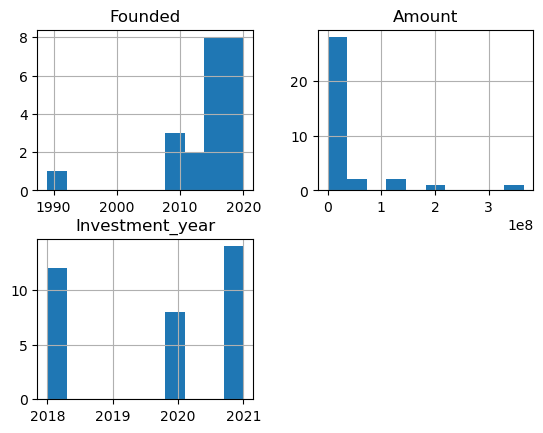

In [423]:
hist = energy.hist()

In [424]:
#Use an ANOVA test (READ ABOUT IT) (Non parametric tests)
#Using the P-Levene to test the Hypothesis
stat, pvalue_levene= stats.levene(fintech.Amount, commerce.Amount, health.Amount,tech.Amount,edu.Amount,agric.Amount,energy.Amount,other.Amount)

print("p value:%.4f" % pvalue_levene)
if pvalue_levene <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.4935
Fail to reject null hypothesis >> The variances of the samples are same.


#### OBSERVATION
- Though the Variances of the samples are the same satisifying the homeostadasicity,the distribution of the samples differ therefore using ANOVA to test the hypothesis will introduce a significant level of error 
- COnducting a non-parametric test will be ideal (the Kruskal-Wallis test)

In [425]:
from scipy.stats import kruskal
stat, p = kruskal(fintech.Amount, commerce.Amount, health.Amount,tech.Amount,edu.Amount,agric.Amount,energy.Amount,other.Amount)
print('Statistics=%.3f, p=%.10f' % (stat, p))

if p > 0.05:
 print('All sample distributions are the same (fail to reject H0)')
else:
 print('One or more sample distributions are not equal distributions (reject null Hypothesis)')

Statistics=35.985, p=0.0000072956
One or more sample distributions are not equal distributions (reject null Hypothesis)


In [426]:
#T-test
stats.f_oneway(fintech.Amount, commerce.Amount, health.Amount,tech.Amount,edu.Amount,agric.Amount,energy.Amount,other.Amount)

F_onewayResult(statistic=0.9150490320762321, pvalue=0.4935132137742656)

In [427]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('Amount~C(Category)', data=df).fit()
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Amount   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8076
Date:                Sat, 09 Mar 2024   Prob (F-statistic):              0.596
Time:                        13:47:54   Log-Likelihood:                -65740.
No. Observations:                2334   AIC:                         1.315e+05
Df Residuals:                    2325   BIC:                         1.316e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               4.057e+06   1.46e+11   2.77e-05      1.000   -2.87e+11    2.87e+11
C(Category)[T.E-commerce & Retail]      6.395e+10   1.48e+11      0.431      0.666   -2.27e+11    3.55e+11
C(Category)[T.Education]                2.874e+07   1.49e+11      0.000      1.000   -2.92e+11    2.92e+11
C(Category)[T.Energy]                   2.817e+07   1.63e+11      0.000      1.000   -3.19e+11    3.19e+11
C(Category)[T.Finance & FinTech]        5.348e+08   1.48e+11      0.004      0.997    -2.9e+11    2.92e+11
C(Category)[T.Healthcare & HealthTech]  1.376e+07    1.5e+11   9.17e-05      1.000   -2.94e+11    2.94e+11
C(Category)[T.Hospitality]              3.012e+06   1.76e+11   1.71e-05      1.000   -3.45e+11    3.45e+11
C(Category)[T.Other]                    2.618e+07   1.47e+11      0.000      1.000   -2.89e+11    2.89e+11
C(Category)[T.Technology & Software]    1.515e+07   1.48e+11      0.000      1.000    -2.9e+11     2.9e+11
==============================================================================
Omnibus:                     7332.715   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        522461842.952
Skew:                          48.075   Prob(JB):                         0.00
Kurtosis:                    2318.840   Cond. No.                         56.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [428]:
anova = sm.stats.anova_lm(model, typ=1)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(Category),$8.00,"$1,107,991,379,299,288,423,071,744.00","$138,498,922,412,411,052,883,968.00",$0.81,$0.60
Residual,"$2,325.00","$398,743,256,252,535,002,470,809,600.00","$171,502,475,807,541,944,123,392.00",NaN,NaN


### Analytical Questions

#### 1. Does location affect the amount of funding or investments?

In [429]:
df.head(2)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,Country,Headquarter_City,Category,Categorised_stage
0,Unbox Robotics,"$2,019.00",Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,"$1,200,000.00",2021,None,Bangalore,Technology & Software,Series A
1,upGrad,"$2,015.00",Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",NaN,"$120,000,000.00",2021,None,Mumbai,Education,Other


In [430]:
#Converting Amount to millions of dollars
df['Amount']=df.Amount/1000
pd.options.display.float_format = '${:,.2f}'.format


In [431]:
startup_loc= df.groupby('Headquarter_City')['Amount'].mean()

startup_loc

Headquarter_City
Ahmedabad                               $10,115.40
Alleppey                                $22,000.00
Ambernath                                  $200.00
Andheri                                  $6,075.00
Bangaldesh                              $22,000.00
Bangalore                               $34,696.77
Bangkok                                  $9,000.00
Banglore                                $32,000.00
Beijing                                $200,000.00
Belgaum                                    $489.42
Bengaluru                                $5,902.89
Berlin                                 $170,000.00
Bhilwara                                 $8,000.00
Bhopal                                     $510.00
Bhubaneswar                             $30,000.00
Bihar                                      $329.00
California                             $769,575.00
Chandigarh                               $4,847.20
Chennai                                 $12,579.52
Cochin        

#### 2. Does the Sector/Category of start up affect the fundings?

In [432]:
startup_cat= df.groupby('Category')['Amount'].max()
startup_cat

Category
Agriculture                       $13,000.00
E-commerce & Retail       $20,000,002,000.00
Education                        $600,000.00
Energy                           $365,000.00
Finance & FinTech            $150,000,000.00
Healthcare & HealthTech          $450,000.00
Hospitality                       $30,000.00
Other                          $3,000,000.00
Technology & Software            $693,000.00
Name: Amount, dtype: float64

In [433]:
#### Graph
##Conclusion

#### 3. How many companies need funding and are at what level of funding ?

In [434]:
startup_stages= df.groupby(['Category','Categorised_stage'])['Sector'].count().sort_values(ascending=False)
startup_stages

Category                 Categorised_stage
Other                    Other                293
                         Seed                 193
                         Series A             181
Technology & Software    Other                161
E-commerce & Retail      Other                123
Finance & FinTech        Other                121
Technology & Software    Seed                 119
                         Series A             112
Education                Other                 86
E-commerce & Retail      Series A              78
Healthcare & HealthTech  Other                 68
Finance & FinTech        Seed                  66
Education                Seed                  60
E-commerce & Retail      Seed                  59
Finance & FinTech        Series A              53
Education                Series A              51
Other                    Series B              49
                         Series C              44
Healthcare & HealthTech  Series A              39
       

#### 4. Which stages give out the highest investment amounts?

In [435]:
startup_sectors= df.groupby('Categorised_stage')['Amount'].max()
startup_sectors

Categorised_stage
Other         $150,000,000.00
Seed              $536,755.02
Series A   $20,000,002,000.00
Series B          $220,000.00
Series C          $275,000.00
Series D          $255,000.00
Series E          $370,000.00
Series F        $2,450,000.00
Series G          $275,000.00
Name: Amount, dtype: float64

#### 5. Which cities have the highest number of startups and at what levels?

In [436]:
startup_cities= df.groupby('Headquarter_City')['Categorised_stage'].count().sort_values(ascending=False)
startup_cities

Headquarter_City
Bangalore                            725
Mumbai                               384
Gurugram                             212
New Delhi                            187
Chennai                               93
Pune                                  76
Hyderabad                             65
Gurgaon                               64
Noida                                 63
Delhi                                 58
Bengaluru                             43
Ahmedabad                             28
Jaipur                                26
Haryana                               21
Kolkata                               17
Thane                                 11
Indore                                10
Gujarat                                6
Jodhpur                                6
San Francisco                          6
Chandigarh                             5
Kochi                                  5
Coimbatore                             4
New York                               4

#### 6. What are the levels of funding the startups are receiving per year?

In [437]:
startup_cities= df.groupby('Investment_year')['Amount'].sum().sort_values(ascending=True)
startup_cities

Investment_year
2019        $3,336,433.20
2018        $6,003,792.41
2020       $90,547,418.60
2021   $20,183,235,443.64
Name: Amount, dtype: float64